In [ ]:
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV

warnings.simplefilter("ignore")
%matplotlib inline

In [ ]:
# !unzip -q /content/drive/MyDrive/Chem_Tech_AI/train_test_data.zip -d /content/data

## Useful Functions

In [ ]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "data"
    X = pd.read_csv(f"{base_path}/{data_path}", parse_dates=[0])
    if "target1" in X.columns:
        y1, y2, y3, y4 = X["target1"], X["target2"], X["target3"], X["target4"]
        X = X.drop(["target1", "target2", "target3", "target4"], axis=1)
        print(f"{data_path}: shape = {X.shape[0]} rows, {X.shape[1]} cols")
        y1[y1.isnull()] = y1.median()
        y2[y2.isnull()] = y2.median()
        y3[y3.isnull()] = y3.median()
        y4[y4.isnull()] = y4.median()
        return X, y1, y2, y3, y4
    else:
        print(f"{data_path}: shape = {X.shape[0]} rows, {X.shape[1]} cols")
        return X

def prepare_data(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Удаление столбцов с количеством значимых элементов меньше 2000.
    Замена пустых значений медианой.
    Переименование признака "Unnamed: 0" и создание на его основе новых 
    признаков (year, month, weekday, hour, day).

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходными данными.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков.

    """
    if copy:
        X = X.copy()

    # X = X.rename(columns = {'Unnamed: 0':'date'}, inplace = True)
    X = X.dropna(axis = 1, thresh=2000)
    X = X.fillna(X.median())
    X["year"] = X["Unnamed: 0"].dt.year
    X["month"] = X["Unnamed: 0"].dt.month
    X["weekday"] = X["Unnamed: 0"].dt.weekday
    X["hour"] = X["Unnamed: 0"].dt.hour
    X["day"] = X["Unnamed: 0"].dt.day
    

    return X


def split_features(df):
    ''' 
    Разделение признаков на категории
    '''
    datetime_features = df.select_dtypes(include=[np.datetime64]).columns
    categorical_features = df.select_dtypes(include=[np.object]).columns
    numerical_features = list(set(df.columns) - set(categorical_features) \
                                              - set(datetime_features))
    return numerical_features, categorical_features, datetime_features

In [ ]:
def predict_target(X_train, X_test, y):
    '''
    XGBRegressor с GridSearchCV

    Parameters
    ----------
    X_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    X_test: pandas.core.frame.DataFrame
        Матрица признаков для предсказания целевых переменных.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.   

    Returns
    ------- 
    y_pred: полученные предсказания

    model_xgbr: обученная модель
    '''


    x_train, x_test, y_train, y_test = train_test_split(X_train, y)

    # Параметры GridSearch для XGBoost
    params = {'max_depth': [3, 7], 
              'n_estimators': [200, 400],
              'min_samples_split':[3, 5]
             }

    # Инициализация xgb и GridSearch
    model_xgbr = xgb.XGBRegressor(nthread=-1) 

    grid = GridSearchCV(model_xgbr, params)
    grid.fit(x_train, y_train)

    # Вывод r2 score
    print(r2_score(y_test, grid.best_estimator_.predict(x_test)))

    y_pred = grid.best_estimator_.predict(X_test)
    return y_pred, model_xgbr


In [ ]:
train, y1, y2, y3, y4 = get_input("train_data_200k.csv")
test = get_input("test_data_100k.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data = prepare_data(data)
data.head(n=2)

train_data_200k.csv: shape = 200000 rows, 80 cols
test_data_100k.csv: shape = 100000 rows, 80 cols


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,Unnamed: 0,tag1,tag2,tag3,tag5,tag7,tag8,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag42,tag43,...,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,year,month,weekday,hour,day
0,2016-08-18 00:00:00,15.78042,0.003691,14.088605,38.39313,47.29479,46.6553,25.30402,60.01311,-0.001269,0.018163,-0.000183,0.000671,0.000956,0.000858,0.000992,18.89847,19.26714,22.33068,15.60123,80.97660,22.33527,33.87122,24.00339,57.06384,44.54309,23.80796,27.63220,47.27997,23.96099,23.94522,26.39192,47.87158,37.12356,36.37045,80.67747,67.609850,41.006095,19.70473,164.9857,...,1.212631,0.0,183.3191,206.6534,69.99840,43.964405,47.33277,50.50632,46.30415,61.20765,72.77773,25.30402,60.01311,2.373747,0.677581,2.775156,1.769055,2.766034,2.794747,33.42513,34.27024,39.65590,44.48986,50.34106,37.34515,53.65030,50.70506,61.08673,72.76518,53.02723,66.30531,55.10297,73.65612,93.74996,56.13752,2016,8,3,0,18
1,2016-08-18 00:01:00,15.80157,0.003691,14.088605,38.39313,53.06440,46.6553,25.30464,60.01566,-0.001289,0.018208,-0.000210,0.000670,0.000947,0.000857,0.001003,25.31277,19.26205,22.35979,15.61021,80.98914,22.33696,33.89564,23.99264,57.05022,44.49367,23.81503,27.63496,47.27994,23.97050,23.93777,26.40619,47.86334,37.09820,36.26917,80.67747,59.162055,41.006095,19.77348,164.1665,...,1.212631,0.0,185.1547,205.3378,69.98409,43.964405,47.33277,50.49541,46.20826,61.20348,72.76062,25.30464,60.01566,2.373543,0.677852,2.775152,1.769295,2.766190,2.794963,33.41073,34.25732,39.70995,44.46941,50.31259,37.34732,53.65897,50.60955,61.09685,72.76947,53.05109,66.30098,55.11534,75.93258,93.74996,56.13752,2016,8,3,0,18


Разбивка фичей на категории

In [ ]:
numerical_features, categorical_features, datetime_features = split_features(data)

In [ ]:
data[numerical_features][:5]

,tag53,tag22,tag21,tag7,tag46,tag49,tag52,tag33,tag45,tag20,tag44,tag59,hour,tag18,tag69,tag62,tag26,tag2,tag24,tag32,tag31,weekday,tag63,tag48,tag5,tag34,tag71,tag51,tag73,tag68,tag77,month,tag43,tag1,tag15,tag60,tag65,tag64,tag38,tag10,tag75,tag79,tag56,tag70,tag19,tag74,tag8,tag57,tag66,tag11,day,tag14,tag35,tag58,tag37,tag17,tag67,tag27,tag25,tag13,tag39,tag76,tag23,tag29,tag55,tag30,tag16,tag12,tag3,tag61,year,tag42,tag72,tag78,tag54,tag50,tag28,tag40,tag47,tag36
0,46.30415,15.60123,22.33068,47.29479,0.0,69.99840,50.50632,23.94522,1.212631,19.26714,17.53541,0.677581,0,0.000992,37.34515,2.766034,24.00339,0.003691,22.33527,23.96099,47.27997,3,2.794747,206.6534,38.39313,26.39192,50.70506,47.33277,72.76518,50.34106,73.65612,8,164.9857,15.78042,0.000671,2.775156,34.27024,33.42513,80.67747,25.30402,66.30531,56.13752,25.30402,53.65030,18.89847,53.02723,46.6553,60.01311,39.65590,60.01311,18,-0.000183,47.87158,2.373747,36.37045,0.000858,44.48986,57.06384,33.87122,0.018163,67.609850,55.10297,80.97660,23.80796,72.77773,27.63220,0.000956,-0.001269,14.088605,1.769055,2016,19.70473,61.08673,93.74996,61.20765,43.964405,44.54309,41.006095,183.3191,37.12356
1,46.20826,15.61021,22.35979,53.06440,0.0,69.98409,50.49541,23.93777,1.212631,19.26205,17.53541,0.677852,0,0.001003,37.34732,2.766190,23.99264,0.003691,22.33696,23.97050,47.27994,3,2.794963,205.3378,38.39313,26.40619,50.60955,47.33277,72.76947,50.31259,75.93258,8,164.1665,15.80157,0.000670,2.775152,34.25732,33.41073,80.67747,25.30464,66.30098,56.13752,25.30464,53.65897,25.31277,53.05109,46.6553,60.01566,39.70995,60.01566,18,-0.000210,47.86334,2.373543,36.26917,0.000857,44.46941,57.05022,33.89564,0.018208,59.162055,55.11534,80.98914,23.81503,72.76062,27.63496,0.000947,-0.001289,14.088605,1.769295,2016,19.77348,61.09685,93.74996,61.20348,43.964405,44.49367,41.006095,185.1547,37.09820
2,46.24781,15.59624,22.38500,47.29479,0.0,70.04832,50.49607,23.92040,1.212631,19.26793,17.53541,0.677734,0,0.001004,37.32831,2.766650,23.98789,0.003691,22.33768,23.96895,47.24675,3,2.795123,206.4609,38.39313,26.36558,50.60200,47.33277,72.75539,50.31557,75.93258,8,166.6839,15.68913,0.000663,2.775619,34.23959,33.41452,91.98822,25.30486,66.30359,55.07365,25.30486,53.66189,18.89847,53.06495,46.6553,60.01267,39.74942,60.01267,18,-0.000146,47.87779,2.373388,36.28939,0.000855,44.45711,57.04745,33.91651,0.018185,67.928570,55.09395,80.94573,23.81206,72.76160,27.63683,0.000957,-0.001310,14.088605,1.768982,2016,19.77574,61.05627,93.74996,61.20309,43.964405,44.52599,41.006095,185.7857,37.10657
3,46.13975,15.60701,22.34216,52.95166,0.0,69.95206,50.51320,23.91153,1.212631,19.24153,17.53541,0.678970,0,0.001003,37.30737,2.766515,23.98795,0.003691,22.33434,23.94341,47.26019,3,2.795122,207.5279,38.39313,26.39959,50.68343,47.33277,72.77387,50.28574,75.93258,8,163.1378,15.75101,0.000672,2.775364,34.23381,33.40705,80.67747,25.30544,66.28421,56.13752,25.30544,53.67104,18.89847,53.06760,46.6553,60.01596,39.79846,60.01596,18,-0.000192,47.91307,2.385501,36.27222,0.000864,44.47630,57.05103,33.98246,0.018180,59.162055,55.12513,80.93867,23.80859,72.77470,27.62737,0.000949,-0.000885,20.262090,1.769024,2016,19.80556,61.00186,92.46913,61.28067,37.132960,44.51584,37.184700,182.6789,37.14546
4,46.33209,15.60543,22.33690,47.29479,0.0,69.99007,50.50373,23.90270,1.212631,19.25176,17.53541,0.678937,0,0.001013,37.30698,2.766815,23.98389,0.003691,22.33530,23.93508,47.20809,3,2.795541,248.1153,38.39313,26.37914,50.64983,47.33277,72.72121,50.23417,73.67016,8,166.8106,15.57773,0.000678,2.775762,34.22705,33.37688,80.67747,25.30540,66.26472,56.13752,25.30540,53.58812,18.89847,53.09679,46.6553,60.01478,39.81411,60.01478,18,-0.000113,47.93106,2.385056,36.26667,0.000865,44.48069,57.05997,34.05027,0.018167,59.162055,55.15526,80.97723,23.76636,72.72731,27.64237,0.000955,-0.001005,14.088605,1.769598,2016,19.79632,61.04366,93.74996,61.28010,43.964405,44.51775,41.006095,186.6251,37.13568


In [ ]:
data[numerical_features] = data[numerical_features].astype(float)

Возвращаем разбивку на train и test в исходное состояние

In [ ]:
df_train, df_test = data[numerical_features].loc[:199999], data[numerical_features].loc[200000:]
df_train.shape, df_test.shape

((200000, 80), (100000, 80))

In [ ]:
id_train, id_test = data["Unnamed: 0"].loc[:199999], data["Unnamed: 0"].loc[200000:]
id_train.shape, id_test.shape

((200000,), (100000,))

Инициализация модели XGBoost

In [ ]:
model_xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:

y_test1, model1 = predict_target(df_train, df_test, y1)

[19:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:18:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:19:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# Сохранение предсказаний в файл

y_test1, model1 = predict_target(df_train, df_test, y1)
y_test2, model2 = predict_target(df_train, df_test, y2)
y_test3, model3 = predict_target(df_train, df_test, y3)
y_test4, model4 = predict_target(df_train, df_test, y4)

y_preds = pd.DataFrame({
    "Unnamed: 0": id_test,
    "target1": y_test1,
    "target2": y_test2,
    "target3": y_test3,
    "target4": y_test4,
    })

y_preds.to_csv("chem_tech_ai.csv", index=False)

[20:12:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
y_preds.to_csv( "/content/drive/MyDrive/Chem_Tech_AI/chem_tech_ai_preds.csv", index=False)

[02:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


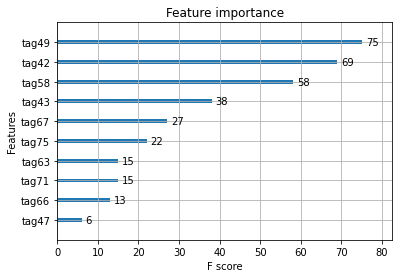

In [ ]:
model1.fit(df_train, y1)
xgb.plot_importance(model1, max_num_features=10)

[02:52:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


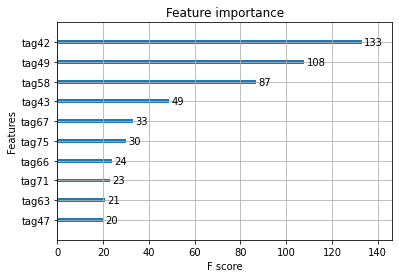

In [ ]:
model2.fit(df_train, y2)
xgb.plot_importance(model2, max_num_features=10)

[02:53:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


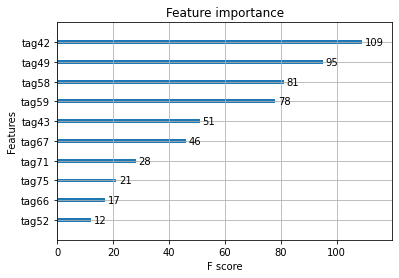

In [ ]:
model3.fit(df_train, y3)
xgb.plot_importance(model3, max_num_features=10)

[02:54:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


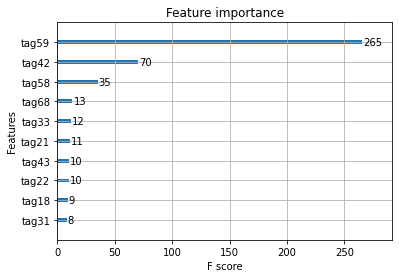

In [ ]:
model4.fit(df_train, y4)
xgb.plot_importance(model4, max_num_features=10)

In [ ]:
preds_ = pd.read_csv("chem_tech_ai_preds.csv")

In [ ]:
preds_

,Unnamed: 0,target1,target2,target3,target4
0,2017-01-03 21:21:00,0.001470,0.065658,0.929308,0.004316
1,2017-01-03 21:22:00,0.001471,0.065466,0.928287,0.004316
2,2017-01-03 21:23:00,0.001463,0.065093,0.928878,0.004316
3,2017-01-03 21:24:00,0.001463,0.065225,0.928359,0.004316
4,2017-01-03 21:25:00,0.001469,0.064943,0.929063,0.004503
...,...,...,...,...,...
99995,2017-03-14 07:56:00,0.001229,0.052446,0.942007,0.005409
99996,2017-03-14 07:57:00,0.001224,0.052171,0.941613,0.005409
99997,2017-03-14 07:58:00,0.001237,0.052601,0.941539,0.005383
99998,2017-03-14 07:59:00,0.001236,0.052258,0.941547,0.005384
